In [17]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt

plt.set_cmap('gray')


objpoints = []
imgpoints = []

for impath in glob.glob('camera_cal/*'):
    imdata_bgr = cv2.imread(impath)
    imdata_gray = cv2.cvtColor(imdata_bgr, cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(imdata_gray, (9, 6))
    if not ret:
        print('Warning: Could not extract corners from chessboard'
              f'image {impath}')
        continue

    imgpoints.append(corners)

    objp = np.zeros((9 * 6, 3), np.float32)
    objp[:,:2] = np.mgrid[:9, :6].T.reshape(-1, 2)
    objpoints.append(objp)


# all images are the same size, so use the shape of the last one
imshape = imdata_gray.shape[::-1]
ret, camera_mtx, camera_dist, _, _ = cv2.calibrateCamera(
    objpoints, imgpoints, imshape, None, None)
    
if not ret:
    raise Exception('Could not calibrate camera!')

Text(0.5,1,'Undistorted')

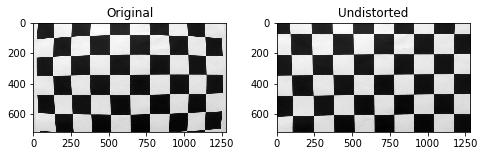

In [18]:
%matplotlib inline

imdata_bgr = cv2.imread('camera_cal/calibration1.jpg')
imdata_gray = cv2.cvtColor(imdata_bgr, cv2.COLOR_BGR2GRAY)
undistorted = cv2.undistort(
    imdata_gray, camera_mtx, camera_dist, None, camera_mtx)
cv2.imwrite('undistorted_example.jpg', undistorted)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 2))
ax1.imshow(imdata_gray)
ax1.set_title('Original')
ax2.imshow(undistorted)
ax2.set_title('Undistorted')

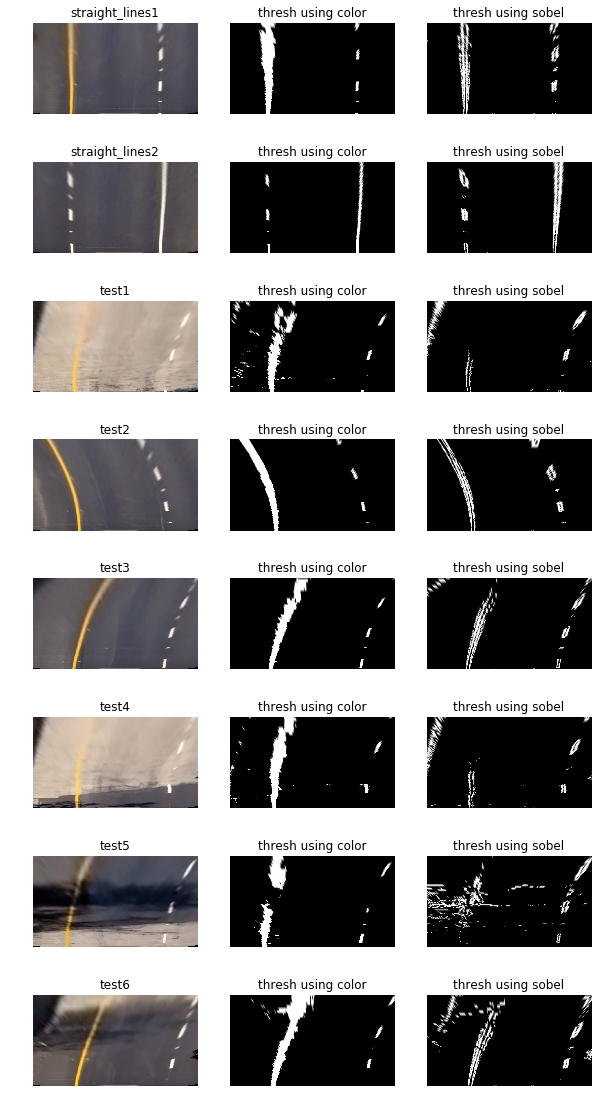

In [19]:
from cached_property import cached_property
import math

def getattr_multi(obj, attrs):
    rv = obj
    for attr in attrs.split('.'):
        rv = getattr(rv, attr)
    return rv


class ImageProcessor:
    OUTPUT_IMGS = [
        'undistorted',
        'lane_lines',
        'p.undistorted',
        'p.lane_lines',
    ]
    SOBEL_MAX = 500

    def __init__(self, path=None, img=None):
        self.path = path
        self._orig = img
    
    @cached_property
    def base_img_name(self):
        if self.path is None:
            return 'noname'
        return self.path.split('/')[-1].split('.')[0]
    
    @property
    def orig(self):
        if self._orig is None:
             self._orig = cv2.cvtColor(
                 cv2.imread(self.path), cv2.COLOR_BGR2RGB)
        return self._orig
    
    @cached_property
    def gray(self):
        return cv2.cvtColor(self.undistorted, cv2.COLOR_RGB2GRAY)

    @cached_property
    def undistorted(self):
        return cv2.undistort(self.orig, camera_mtx, camera_dist,
                             None, camera_mtx)
    
    @cached_property
    def fixed_perspective_transform_matrices(self):
        # hardcoded input points gotten from looking at image in GIMP
        src = np.float32([
            [595, 450],  # top left
            [685, 450],  # top right
            [244, 686],  # bottom left
            [1063, 686],  # bottom right
        ])

        margin_x = 200
        margin_y = 0
        size = 500
        dst = np.float32([
            [margin_x, margin_y],  # top left
            [margin_x + size - 1, margin_y],  # top right
            [margin_x, margin_y + size - 1],  # bottom left
            [margin_x + size - 1, margin_y + size - 1],  # bottom right
        ])

        M = cv2.getPerspectiveTransform(src, dst)
        Minv = cv2.getPerspectiveTransform(dst, src)
        out_dims = (size + margin_x * 2, size + margin_y * 2)
        out_dims_inv = (self.orig.shape[1], self.orig.shape[0])
        
        return M, Minv, out_dims, out_dims_inv

    def fixed_perspective_transform(self, img):
        M = self.fixed_perspective_transform_matrices[0]
        out_dims = self.fixed_perspective_transform_matrices[2]
        
        return cv2.warpPerspective(
            img,
            M,
            out_dims,
        )
    
    @cached_property
    def saturation(self):
        return cv2.cvtColor(self.undistorted, cv2.COLOR_RGB2HLS)[:,:,2]

    def sobel(self, img, x, y):
        sobel = cv2.Sobel(
            img, cv2.CV_64F, x, y)
        abs_sobel = np.abs(sobel)
        scaled_sobel = 255 * np.clip(
            abs_sobel / self.SOBEL_MAX,
            0, 1)
        return np.uint8(scaled_sobel)
    
    def sobel_mag(self, sobel_x, sobel_y):
        return np.uint8(np.sqrt(
            np.power(sobel_x, 2, dtype=np.float32)
            + np.power(sobel_y, 2, dtype=np.float32)
        ) / math.sqrt(2))

    @cached_property
    def gray_sobel_x(self):
        return self.sobel(self.gray, 1, 0)
    
    @cached_property
    def gray_sobel_y(self):
        return self.sobel(self.gray, 0, 1)
    
    @cached_property
    def gray_sobel_mag(self):
        return self.sobel_mag(self.gray_sobel_x, self.gray_sobel_y)
        
    @cached_property
    def sat_sobel_x(self):
        return self.sobel(self.saturation, 1, 0)
        
    @cached_property
    def sat_sobel_y(self):
        return self.sobel(self.saturation, 0, 1)

    @cached_property
    def sat_sobel_mag(self):
        return self.sobel_mag(self.sat_sobel_x, self.sat_sobel_y)
    
    def sobel_angle(self, img):
        # angle of the gradient
        # taken modulo pi so that e.g. up and to the right is the
        # same as down and to the left
        # 0 represents 0 rad, 255 represents pi rad
        sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, 5)
        sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, 5)
        ang = np.arctan2(sobel_y, sobel_x)
        ang = np.mod(ang, math.pi)
        return np.uint8(ang * 255 / math.pi)
    
    def sobel_angle_thresh(self, img):
        min_degrees = 30
        max_degrees = 60
        min_val = min_degrees * 255 / 180
        max_val = max_degrees * 255 / 180
        opp = 255 - img
        binary_mask = (
            (img > min_val)
             & (img < max_val)
            | (opp > min_val)
               & (opp < max_val)
        )
        return np.uint8(binary_mask) * 255
    
    @cached_property
    def gray_sobel_angle_thresh(self):
        return self.sobel_angle_thresh(self.gray)

    @cached_property
    def sat_sobel_angle_thresh(self):
        return self.sobel_angle_thresh(self.saturation)
    
    @cached_property
    def combined_sobel_thresh(self):
        gray_binary = (
            (self.gray_sobel_x > 63)
            & (self.gray_sobel_y > 63)
            | self.gray_sobel_angle_thresh
              & (self.gray_sobel_mag > 63)
        )
        sat_binary = (
            (self.sat_sobel_x > 63)
            & (self.sat_sobel_y > 63)
            | self.sat_sobel_angle_thresh
              & (self.sat_sobel_mag > 63)
        )
        binary = gray_binary | sat_binary
        return np.uint8(255 * binary)

    @cached_property
    def yellow(self):
        hsv = cv2.cvtColor(self.undistorted, cv2.COLOR_RGB2HSV)
        h = hsv[:,:,0]
        s = hsv[:,:,1]
        binary = (15 <= h) & (h <= 30) & (s > 55)
        return np.uint8(binary * 255)
    
    @cached_property
    def white(self):
        hsv = cv2.cvtColor(self.undistorted, cv2.COLOR_RGB2HSV)
        s = hsv[:,:,1]
        v = hsv[:,:,2]
        binary = (s < 32) & (v >= 200) 
        return np.uint8(binary * 255)
    
    @cached_property
    def y_or_w(self):
        return self.yellow | self.white
    
    @property
    def lane_lines(self):
        return self.y_or_w

    @property
    def p(self_outer):
        class PerspectiveTransformer:
            def __getattr__(self, name):
                return self_outer.fixed_perspective_transform(
                    getattr(self_outer, name))

        return PerspectiveTransformer()

    def save(self):
        for prop in self.OUTPUT_IMGS:
            img = getattr_multi(self, prop)
            
            if len(img.shape) == 2:
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
            else:
                img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

            prop = prop.replace('p.', 'perspective_')

            cv2.imwrite(
                f'output_images/{self.base_img_name}_{prop}.jpg',
                img)


all_images = sorted(glob.glob('test_images/*'))
_, axes = plt.subplots(len(all_images), 3, figsize=(10, 20))

for idx, path in enumerate(all_images):
    imp = ImageProcessor(path)
    axes[idx][0].imshow(imp.p.undistorted)
    axes[idx][0].set_title(imp.base_img_name)
    axes[idx][0].axis('off')
    axes[idx][1].imshow(imp.p.lane_lines)
    axes[idx][1].set_title('thresh using color')
    axes[idx][1].axis('off')
    axes[idx][2].imshow(imp.p.combined_sobel_thresh)
    axes[idx][2].set_title('thresh using sobel')
    axes[idx][2].axis('off')


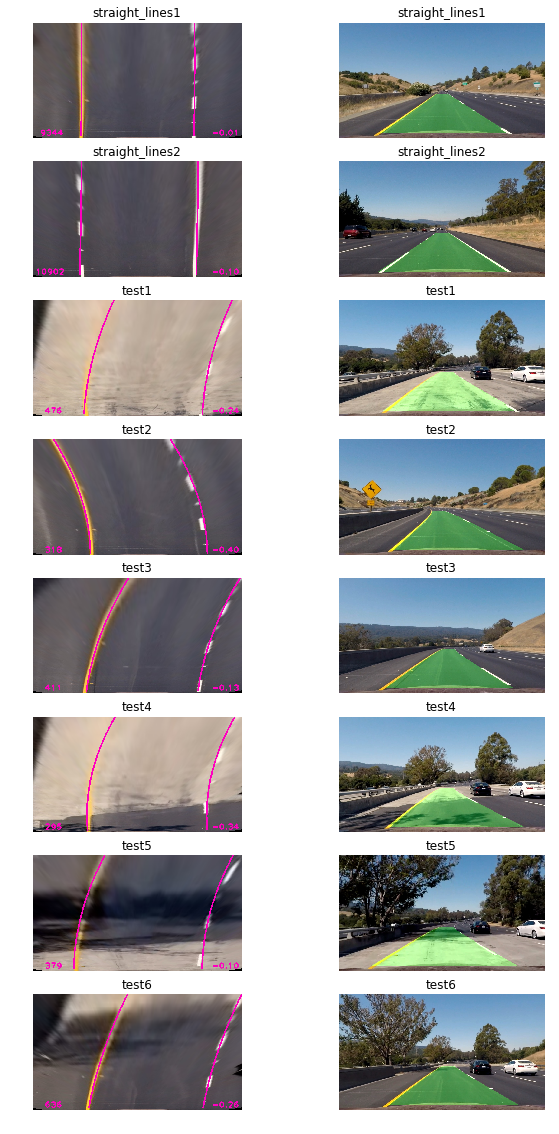

In [21]:
import iterutils

class LaneTracer(ImageProcessor):
    OUTPUT_IMGS = ImageProcessor.OUTPUT_IMGS + [
        'lane_points_viz',
        'lane_coeffs_viz',
        'lane_curvature_car_pos_viz',
        'drivable_area_viz',
    ]
    N_WINDOWS = 10
    WINDOW_WIDTH = 50
    SEARCH_RADIUS = 100
    # in straight_lines1, lane line centers are about 493 px apart
    X_METERS_PER_PIX = 3.7 / 493
    # in straight_lines1, dashed lane markers are about 55 px long
    Y_METERS_PER_PIX = 3 / 55

    @cached_property
    def horiz_blur(self):
        return cv2.GaussianBlur(
            self.p.lane_lines, (2 * self.WINDOW_WIDTH - 1, 1), 0)
    
    @cached_property
    def lane_points(self):
        # calculate points that trace lanes from self.lane_lines using
        # a sliding window search
        # returns left_lane_points, right_lane_points in the
        # perspective-transformed coordinate space
        
        # compute histogram of lower third of image
        height, width = self.p.lane_lines.shape
        window_height = height // self.N_WINDOWS
        hist = np.sum(self.p.lane_lines[-height // 3:, :], axis=0)
        
        left_peak = np.argmax(hist[:width // 2])
        right_peak = width // 2 + np.argmax(hist[width // 2:])
        
        # Note: in the lectures, np.convolve was used to find the
        # position for each sliding window that maximized the number
        # of active pixels it contained. Here, I'll simply use
        # cv2.gaussianBlur to achieve roughly the same thing with
        # a little less code.
        horiz_blur = cv2.GaussianBlur(
            self.p.lane_lines, (2 * self.WINDOW_WIDTH - 1, 1), 0)
        
        left_lane_points = [
            (left_peak, None),  # will be removed
        ]
        right_lane_points = [
            (right_peak, None),  # will be removed
        ]
        
        for y in range(
                height - window_height // 2, 0, -window_height):
            for pts in [left_lane_points, right_lane_points]:
                x_prev = pts[-1][0]
                low = (
                    x_prev
                    - self.WINDOW_WIDTH // 2
                    - self.SEARCH_RADIUS)
                low = np.clip(low, 0, width)
                high = (
                    x_prev
                    + self.WINDOW_WIDTH // 2
                    + self.SEARCH_RADIUS)
                high = np.clip(high, 0, width)
                
                rowhist = np.sum(
                    horiz_blur[y - window_height // 2
                               :y + window_height // 2,
                               low:high], axis=0)
                
                maxpos = np.argmax(rowhist)
                # only move if we detected enough pixels
                if rowhist[maxpos] > 50:
                    x = low + maxpos
                else:
                    x = x_prev

                pts.append((x, y))
        
        return left_lane_points[1:], right_lane_points[1:]
    
    @cached_property
    def lane_points_viz(self):
        rv = np.copy(self.p.undistorted)
        for pt in iterutils.flatten(self.lane_points):
            cv2.circle(rv, pt, 10, (255, 0, 191), -1)
        
        return rv
    
    @cached_property
    def lane_width_pix(self):
        left_points, right_points = np.array(self.lane_points)
        return np.mean(right_points[:, 0]) - np.mean(left_points[:, 0])

    @cached_property
    def lane_coeffs(self):
        # return A, B, and C in x = Ay^2 + By + C for the left and
        # right lanes
        
        # assume that left and right lanes are parallel, fit a single
        # quadratic to both of them
        pts = np.array(self.lane_points, dtype=np.float32)
        pts[1,:,0] -= self.lane_width_pix
        pts = pts.reshape(-1, 2)
        
        left_fit = np.polyfit(pts[:,1], pts[:,0], 2)
        right_fit = np.copy(left_fit)
        right_fit[2] += self.lane_width_pix
        
        return left_fit, right_fit
    
    def draw_func_y(self, img, func, color=(255, 0, 191),
                    thickness=5):
        # draw a mathematical function on the image, defined as
        # x = func(y)
        x_prev = int(round(func(0)))
        y_prev = 0
        for y in range(10, img.shape[0], 10):
            x = int(round(func(y)))
            cv2.line(img, (x_prev, y_prev), (x, y), color, thickness)
            x_prev = x
            y_prev = y

    @cached_property
    def lane_coeffs_viz(self):
        rv = np.copy(self.p.undistorted)

        for coeffs in self.lane_coeffs:
            A, B, C = coeffs
            func = lambda y: A * y * y + B * y + C

            self.draw_func_y(rv, func)
        
        return rv
    
    @cached_property
    def lane_curvature_car_pos_viz(self):
        rv = np.copy(self.lane_coeffs_viz)

        if self.curvature_m >= 1e5:
            curv_str = '>100k'
        else:
            curv_str = f'{self.curvature_m:5.0f}'
        cv2.putText(
            rv,
            curv_str,
            (10, rv.shape[0] - 10),
            cv2.FONT_HERSHEY_PLAIN,
            2.5,  # fontScale
            (255, 0, 191),
            3,  # thickness
            cv2.LINE_AA,  # lineType anti-aliased
        )
        
        pos_str = f'{self.center_offset_m:5.2f}'
        cv2.putText(
            rv,
            pos_str,
            (rv.shape[1] - 130, rv.shape[0] - 10),
            cv2.FONT_HERSHEY_PLAIN,
            2.5,  # fontScale
            (255, 0, 191),
            3,  # thickness
            cv2.LINE_AA,  # lineType anti-aliased
        )
        return rv

    @cached_property
    def curvature_m_using_ellipse(self):
        # this doesn't quite work because the axes of the ellipse
        # aren't exactly aligned with X and Y axes of image, esp
        # when car isn't aimed straight down the lane
        A, B, _ = self.lane_coeffs[0]
        y = self.p.undistorted.shape[0]
        curvature_p = (
            (1 + (2 * A * y + B) ** 2) ** (3 / 2)
            / abs(2 * A)
        )
        
        # ellipse curvature formula
        horiz_axis = curvature_p * self.X_METERS_PER_PIX
        vert_axis = curvature_p * self.Y_METERS_PER_PIX
        curvature_real = vert_axis ** 2 / horiz_axis
        return curvature_real
    
    @cached_property
    def curvature_m(self):
        # calculate curvature in real-world coordinate space
        pts = np.array(self.lane_points, dtype=np.float32)
        lane_width = np.mean(pts[1,:,0] - pts[0,:,0])
        pts[1,:,0] -= lane_width
        pts = pts.reshape(-1, 2)
        
        pts[:, 0] *= self.X_METERS_PER_PIX
        pts[:, 1] *= self.Y_METERS_PER_PIX
        
        A, B, _ = np.polyfit(pts[:, 1], pts[:, 0], 2)
        y = self.p.undistorted.shape[0] * self.Y_METERS_PER_PIX

        curvature_real = (
            (1 + (2 * A * y + B) ** 2) ** (3 / 2)
            / abs(2 * A)
        )

        return curvature_real
    
    @cached_property
    def center_offset_m(self):
        # negative means car is to the left of the center line, positive means car is to the right
        car_center = self.lane_points_viz.shape[1] / 2
        lane_center = self.lane_points[0][0][0] + self.lane_width_pix / 2
        
        return (car_center - lane_center) * self.X_METERS_PER_PIX

    @cached_property
    def drivable_area_viz(self):
        viz_p = np.zeros_like(self.lane_coeffs_viz).astype(np.uint8)
        
        ys = np.array(
            range(0, self.lane_coeffs_viz.shape[0] + 1, 10),
            dtype=np.float32)
        (Al, Bl, Cl), (Ar, Br, Cr) = self.lane_coeffs
        xsl = Al * ys * ys + Bl * ys + Cl
        xsr = Ar * ys * ys + Br * ys + Cr
        
        ys = list(ys) + list(reversed(ys))
        xs = list(xsl) + list(reversed(xsr))
        pts = np.vstack([xs, ys]).T.astype(np.int32)

        cv2.fillConvexPoly(viz_p, pts, (0, 255, 0))
        
        Minv = self.fixed_perspective_transform_matrices[1]
        out_dims_inv = self.fixed_perspective_transform_matrices[3]
        
        viz = cv2.warpPerspective(
            viz_p,
            Minv,
            out_dims_inv,
        )
        
        viz = cv2.addWeighted(self.undistorted, 1, viz, 0.3, 0)

        return viz


_, axes = plt.subplots(len(all_images), 2, figsize=(10, 20))

for idx, path in enumerate(all_images):
    lt = LaneTracer(path)
    axes[idx][0].imshow(lt.lane_curvature_car_pos_viz)
    axes[idx][0].set_title(lt.base_img_name)
    axes[idx][0].axis('off')
    axes[idx][1].imshow(lt.drivable_area_viz)
    axes[idx][1].set_title(lt.base_img_name)
    axes[idx][1].axis('off')
    lt.save()

In [ ]:
from moviepy.editor import VideoFileClip

def process(frame):
    lt = LaneTracer(img=frame)
    return lt.drivable_area_viz

inclip = VideoFileClip('project_video.mp4')
outclip = inclip.fl_image(process)
%time outclip.write_videofile('outvid.mp4', audio=False)